In [1]:
using CSV
using MLBase
using Distances
using Clustering
using DataFrames
using StatsBase
using Hungarian
using LinearAlgebra
using JLD
using SparseArrays
using MultivariateStats

using CairoMakie

In [2]:
function ground_true(df_1, df_2)
    a = fill(1,size(df_1)[1])
    b = fill(2,size(df_2)[1])
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

plot_clusters (generic function with 1 method)

In [13]:
function hc_label(matrix; linkage=:ward)
    H = hclust(matrix,linkage = linkage)
    return pred = cutree(H, k=2)
end

function hc_matrix(trees, path)
    n = length(trees)
    result = zeros(n, n)
    for i in 2:n
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            matrix = pairwise(Euclidean(), tree, dims=2)
            pred = hc_label(matrix)
            m,x = accuracy(2, gt, pred)
            result[i,j] = x
            result[j,i] = x
        end
    end      
    header = Vector(1:n)
    header = string.(header)
    CSV.write(path, DataFrame(result, :auto),header = header);
end

hc_matrix (generic function with 1 method)

In [4]:
tree1 = CSV.read("data/4_diff_topo_1_1000_11.csv", DataFrame);
tree2 = CSV.read("data/4_diff_topo_12_1000_11.csv", DataFrame);
tree1 = Matrix(tree1);
tree2 = Matrix(tree2);

In [5]:
gt = ground_true(tree1, tree2);
tree = vcat(tree1,tree2)
tree = standardize_tree(tree)
matrix = pairwise(Euclidean(), tree, dims=2)

2000×2000 Matrix{Float64}:
 0.0      2.46335   3.78485  3.04128   …  3.88734  3.19706   3.54466  1.70883
 2.46335  0.0       1.76889  1.19011      3.20002  2.79139   3.61546  3.18635
 3.78485  1.76889   0.0      1.88484      3.58369  3.88082   4.20073  3.9753
 3.04128  1.19011   1.88484  0.0          3.1761   3.26025   4.20692  3.90283
 2.36995  0.186304  1.92625  1.14487      3.19328  2.73297   3.62402  3.17694
 4.13229  3.08211   2.79052  2.12066   …  3.89832  4.40585   5.02635  4.8097
 3.44804  2.2683    2.51993  1.22312      3.26671  3.67798   4.47923  4.37614
 2.98436  0.66633   1.60152  0.820364     2.99463  3.06745   3.86802  3.75479
 4.27148  3.30917   3.01911  2.34531      3.9598   4.54845   5.12981  4.96184
 3.52889  2.70491   3.68493  2.82504      2.35278  3.56755   3.85483  4.68026
 3.60985  1.61534   1.09269  1.25252   …  3.90433  3.91824   4.69664  3.9501
 1.43957  1.20566   2.67182  2.02841      3.57565  2.42734   3.28014  2.35753
 8.89619  7.62969   6.34704  8.20222    

In [7]:
pred = hc_label(matrix)
accuracy(2, gt, pred)

([846 154; 22 978], 0.912)

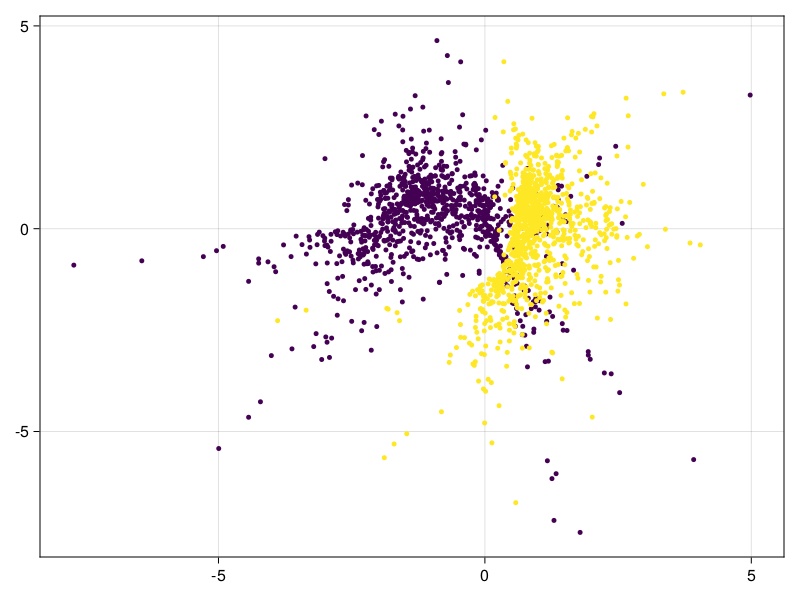

In [8]:
plot_clusters(tree, gt)

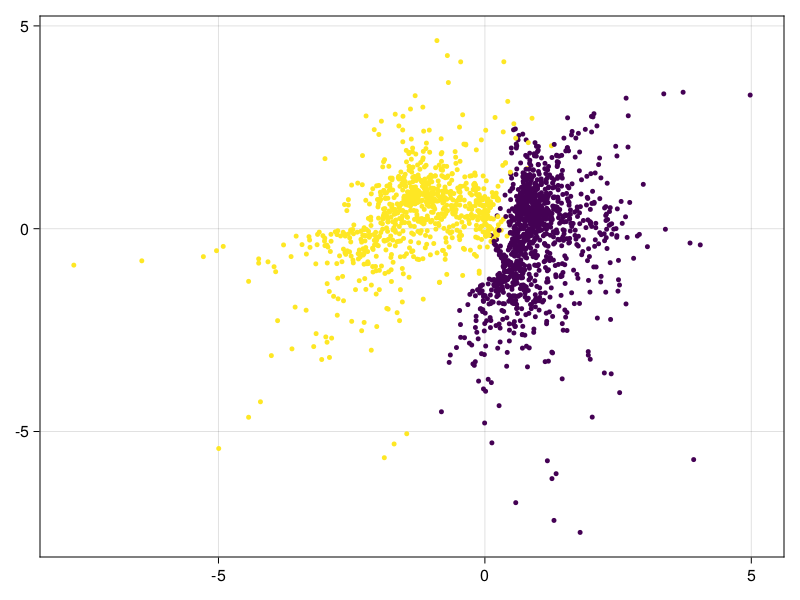

In [9]:
plot_clusters(tree, pred)

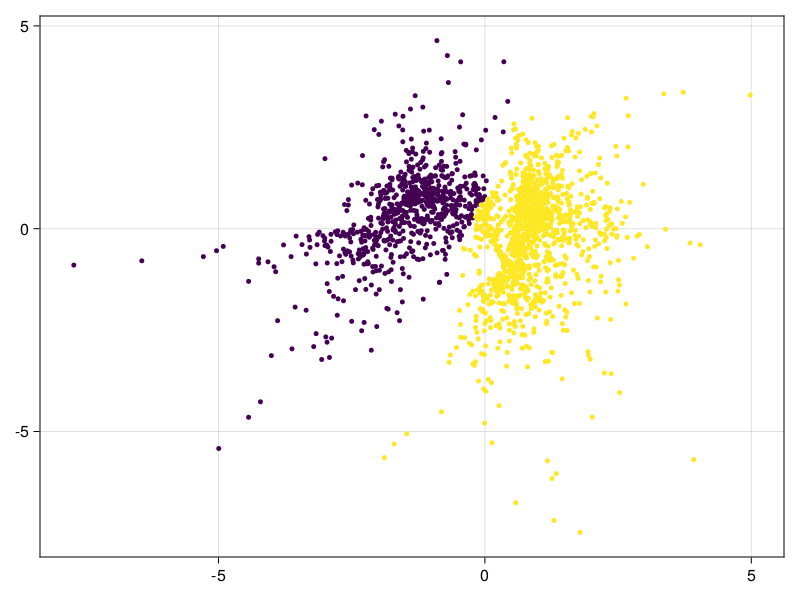

In [10]:
k_pred = kmeans(tree, 2).assignments
plot_clusters(tree, k_pred)

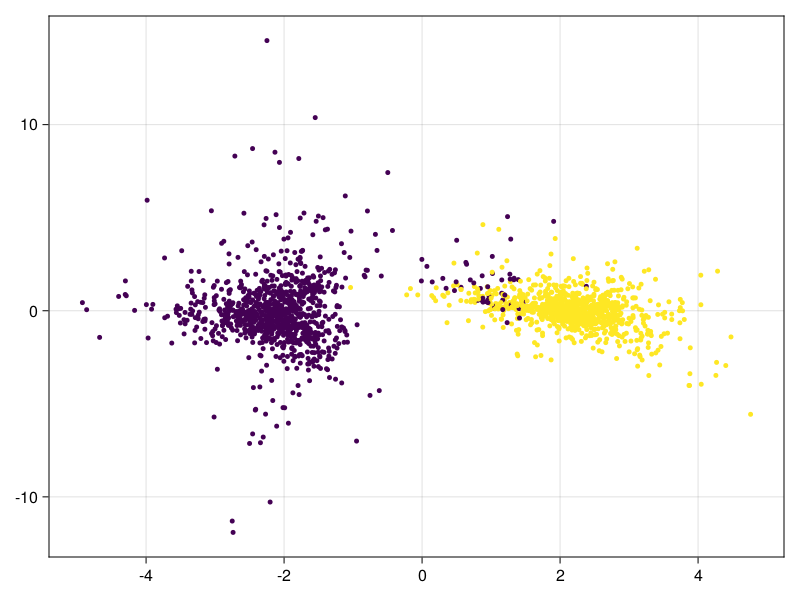

In [11]:
tree1 = CSV.read("data/8_diff_topo_1_1000_11.csv", DataFrame);
tree2 = CSV.read("data/8_diff_topo_12_1000_11.csv", DataFrame);
tree1 = Matrix(tree1);
tree2 = Matrix(tree2);
gt = ground_true(tree1, tree2);
tree = vcat(tree1,tree2)
tree = standardize_tree(tree)
matrix = pairwise(Euclidean(), tree, dims=2)
pred = hc_label(matrix)
k_pred = kmeans(tree, 2).assignments

plot_clusters(tree, pred)

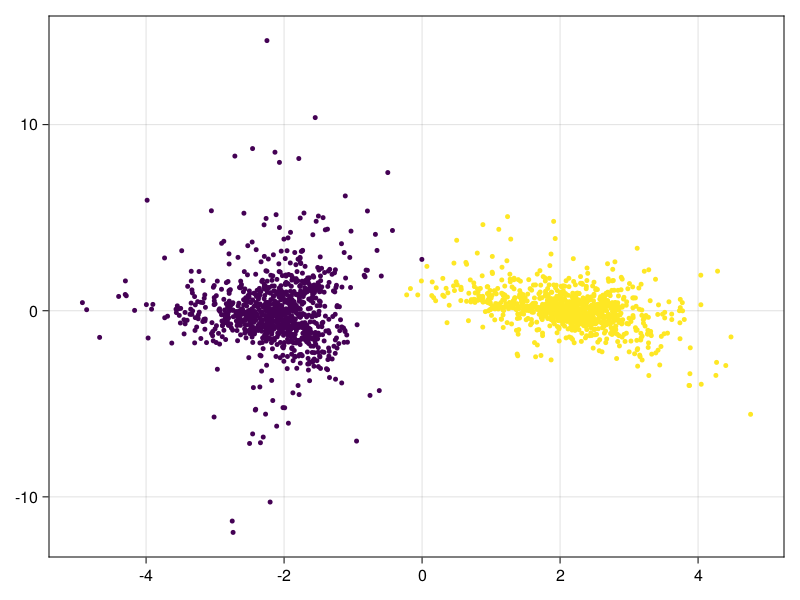

In [12]:
plot_clusters(tree, k_pred)

In [116]:
for i in 1:100
    trees = []
    for j in 1:15
        path = "data/4_diff_topo_" * string(j) *  "_50_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end

    hc_matrix(trees, "data/hc/hc_4_diff_topo_50_" * string(i) * ".csv");
end


In [117]:
for i in 1:100
    trees = []
    for j in 1:15
        path = "data/4_diff_topo_" * string(j) *  "_100_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end

    hc_matrix(trees, "data/hc/hc_4_diff_topo_100_" * string(i) * ".csv");
end


In [ ]:
for i in 1:100
    trees = []
    for j in 1:15
        path = "data/4_diff_topo_" * string(j) *  "_500_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end

    hc_matrix(trees, "result/hc/hc_4_diff_topo_500_" * string(i) * ".csv");
end

In [118]:
for i in 1:100
    trees = []
    for j in 1:15
        path = "data/4_diff_topo_" * string(j) *  "_1000_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end

    hc_matrix(trees, "data/hc/hc_4_diff_topo_1000_" * string(i) * ".csv");
end

In [ ]:
Threads.@threads for i in 1:100
    print("$i ")
    trees = []
    for j in 1:15
        path = "data/4-taxa/4_diff_topo_" * string(j) *  "_5000_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end

    hc_matrix(trees, "result/hc/hc_4_diff_topo_5000_" * string(i) * ".csv");
end

In [13]:
for i in 1:100
    trees = []
    for j in 1:15
        path = "data/8_diff_topo_" * string(j) *  "_50_" * string(i) * ".jld"
        tree = jldopen(path, "r") do file
            read(file, "tree")
        end
        push!(trees, tree)
    end

    hc_matrix(trees, "data/hc/hc_8_diff_topo_50_" * string(i) * ".csv");
end
